In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import sys

### Data

In [2]:
import matplotlib.pyplot as plt

In [3]:
from utils.dataset import get_dataset_by_name
# Data, modelling and hyperparameters setup


In [4]:
class LossHistory(object):
    
    def __init__(self, name):
        self.name = name
        self.crm_loss = []
        self.online_loss = []
        self.betas = []
        self.n_samples = []
        self.n_actions = []
        self.cumulated_loss = []
        self.regret = []
        
    def update(self, beta, online_loss, regret, crm_loss, cumulated_losses, n_samples):
        self.betas += [beta]
        self.online_loss += [online_loss]
        self.crm_loss += [crm_loss]
        self.n_samples += [n_samples]
        self.cumulated_loss += [np.sum(self.cumulated_loss) + cumulated_losses]
        self.regret += [np.sum(self.regret) + regret*n_samples] 
        
    def show_last(self):
        print(
            '<', self.name,
            'CRM loss: %.5f' % self.crm_loss[-1],
            'Online loss: %.5f' % self.online_loss[-1],
            '|beta|=%.2f' % np.sqrt((self.betas[-1]**2).sum()), 
            'n=%d' % sum(self.n_samples),
            '>',
            file=sys.stderr
        )
    

min_max_scaler = preprocessing.MinMaxScaler()

In [163]:
contexts[0]

from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler().fit(contexts)

X_scaled = scaler.transform(contexts)
X_scaled[0]

array([1.        , 1.        , 0.        , 0.        , 1.        ,
       0.55555556, 0.        , 0.69895761, 0.22287678, 0.15883553,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 1.     

In [211]:
class Model():
    
    def __init__(self, name, random_seed):
        self.name = name
        self.rng = np.random.RandomState(random_seed)
    
    def create_start_parameter(self, dataset):
        d = dataset.dimension
#         parameter_scale = dataset.parameter_scale
        parameter_scale = 0.001
        
        if self.name == 'linear':
#             return self.rng.normal(scale=0.1, size=d + 2)
            return np.concatenate([np.array([30.]), self.rng.normal(scale=parameter_scale, size=d)])
#             return theta

        elif self.name == 'polynomial':
            return np.concatenate([np.array([1]), self.rng.normal(scale=parameter_scale, size=d ** 2 + d)])
        else:
            return

    def _linear_modelling(self, parameter, features):
#         intercept_coeff, mean_coeff, var = parameter[0], parameter[1:-1], parameter[-1]
        intercept_coeff, mean_coeff = parameter[0], parameter[1:]
        mean = jnp.dot(features, mean_coeff) + intercept_coeff
        return mean
    
    def _polynomial_modelling(self, parameter, features):
        n = features.shape[1]
#         intercept, coeff_lin, coeff_kern, var = parameter[0], parameter[1:n + 1], parameter[n + 1:-1], parameter[-1]
        intercept, coeff_lin, coeff_kern = parameter[0], parameter[1:n + 1], parameter[n + 1:]
    
        m_linear = jnp.dot(features, coeff_lin) + intercept
        f = jnp.einsum('ij,ih->ijh', features, features).reshape(features.shape[0], -1)
        m_kern = jnp.dot(f, coeff_kern)
        mean = m_kern + m_linear
        return mean
    
    def get_parameter(self, parameter, features):
        if self.name == 'linear':
            return self._linear_modelling(parameter, features)
        elif self.name == 'polynomial':
            return self._polynomial_modelling(parameter, features)
        else:
            return  

        

In [200]:
actions, contexts, losses, propensities, potentials = dataset.get_logged_data()

from sklearn.linear_model import LogisticRegression, RidgeCV

pistar_determinist = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])

pistar_determinist.fit(contexts, potentials)
theta = np.concatenate([np.array([pistar_determinist.intercept_]), pistar_determinist.coef_])

theta

array([ 3.09444191e+01, -2.99914660e-01,  2.50508140e+00, -3.54007232e-02,
       -1.34667392e+00,  1.92025779e+00, -2.10716662e+00, -1.34182841e+01,
       -9.25484308e-02,  3.52789084e-01, -5.32217486e-01,  2.60917045e+00,
        2.74296594e+00, -2.14582874e+00,  2.52708359e+00, -2.37019709e-01,
       -1.05003685e+00, -2.44087902e+00,  5.61649403e-01, -4.56842534e+00,
       -4.32941813e+00,  9.86801612e-01, -2.23307271e-01,  1.39775252e+00,
        6.87573480e-01, -5.37944209e-02,  2.23085096e-01,  1.48073697e+00,
        6.38131935e-02,  9.36038587e-01, -2.22920199e+00, -3.47076115e+00,
        1.09526395e+01,  7.42127392e+00,  8.33726884e+00,  6.79315341e+00,
       -3.44119804e+00, -2.44403974e-02,  3.99717847e-01,  1.14192209e+01,
        9.19962549e+00,  1.31437949e+00,  6.09866544e+00,  3.86756654e-01,
       -1.80632783e+00,  1.54302272e+01,  9.98281616e-01,  1.16042509e+01,
       -3.40471088e+01,  2.01003019e-01,  5.48240131e+00, -7.05481374e+00,
       -9.34651491e-01, -

In [201]:
contextual_modelling = Model(settings['contextual_modelling'], random_seed)

for _ in range(10):
    eps = np.random.normal(0, 1, theta.shape[0])
    contextual_param = contextual_modelling.get_parameter(theta+eps, contexts)
    importance_weights = pdf(contextual_param, actions)/propensities
    print('offline', np.mean(losses * importance_weights))
    sampled_actions = np.random.normal(contextual_param, logging_scale, contexts.shape[0])
    
    print('online', np.mean(dataset.get_losses_from_actions(potentials, sampled_actions)))

offline 8.1593075
online 48.58984414779437
offline 6.6140842
online 6.979501081267916
offline 0.006446837
online 92.04620196878903
offline 0.01014757
online 77.48122701354532
offline 8.950615
online 31.707360756105682
offline 1.3685005
online 81.90833291808823
offline 0.0
online 292.8436643919409
offline 0.0
online 228.13696224266982
offline 1.979099
online 64.1461619346628
offline 5.6964245
online 54.46331881454548


In [202]:
import jax
import jax.numpy as jnp
import jaxopt

logging_scale = 1

def pdf(loc, x):
    scale = logging_scale
    return 1/(scale * jnp.sqrt(2*jnp.pi)) * jnp.exp(-((x - loc)/scale)**2/2)

class Estimator():
    def __init__(self, contextual_modelling, mode='conservative', lbd=0.1):
        self.contextual_modelling = contextual_modelling
        self.mode = mode
        bonus = 1 if self.mode == 'conservative' else -1
        self.lbd = bonus * lbd
        
    def objective_function(self, param, actions, contexts, losses, propensities):
        
        contextual_param = self.contextual_modelling.get_parameter(param, contexts)
        propensities = jnp.clip(propensities, 1e-5, None)
        importance_weights = pdf(contextual_param, actions)/propensities
        mean = jnp.mean(losses * importance_weights)
        std = jnp.std(losses * importance_weights)
        lambda2 = .0
        norm_parameter = jnp.linalg.norm(param[1:])
        return mean + self.lbd * std + lambda2 * norm_parameter
    
    
def optimize(loss_fun, init_parameter, args):
    
#     import ipdb; ipdb.set_trace()
    lbfgsb = jaxopt.ScipyMinimize(fun=loss_fun, method="L-BFGS-B").run(init_parameter, *args)
    lbfgs_sol = lbfgsb.params
    lbfgs_fun_val = lbfgsb.state.fun_val
    
    return lbfgs_sol, lbfgs_fun_val

# Experiment

In [203]:
def get_logging_data(n_samples, dataset):

    start = 0
    end = n_samples
    
    actions = dataset.actions_train[start:end]
    contexts = dataset.features_train[start:end, :]
    losses = dataset.losses_train[start:end]
    propensities = dataset.propensities_train[start:end]

    logging_data = actions, contexts, losses, propensities
    return logging_data

def sample_data(n_samples, index, dataset):

    start = n_samples * index
    end = start + n_samples
    
    contexts = dataset.features_train[start:end, :]
    potentials = dataset.potentials_train[start:end]

    return contexts, potentials

def update_past_data(data, samples):
    return np.hstack([data, samples])

In [204]:
import os


def online_evaluation(optimized_param, contextual_modelling, dataset, random_seed):
    
    rng = np.random.RandomState(random_seed)
    contexts, potentials = dataset.test_data
    contextual_param = contextual_modelling.get_parameter(optimized_param, contexts)
    size = contexts.shape[0]
    losses = []
    
    for i in range(10):
        sampled_actions = rng.normal(contextual_param, logging_scale, size)
        losses += [dataset.get_losses_from_actions(potentials, sampled_actions)]
        
    losses_array = np.stack(losses, axis=0)
    var_pi = np.mean(np.var(losses_array, axis=0))
    var_context = np.var(np.mean(losses_array, axis=1))
    return np.mean(losses_array), np.std(np.mean(losses_array, axis=0))
    
def start_experiment(random_seed, dataset, name):
    print(
        '***', 'EXPERIMENT', name,
        'Random seed: %i' % random_seed,
        'Dataset: %s' % dataset.name,
        '***',
        file=sys.stderr
    )

In [ ]:
from blbla import Class1
from blabla2 import

ppo = Class1() 

ppo.mlp_network = Mlp

In [205]:
M = 10

In [206]:
dataset_name = 'warfarin'
settings = {
    'lambda': 0.1,
    'contextual_modelling': 'linear'
}

dataset = get_dataset_by_name(dataset_name)

In [207]:
T = dataset.actions_train.shape[0]

In [208]:
dataset.actions_train.mean()

32.25353328587548

In [209]:
dataset.actions_test.shape

(1322,)

### Same sampling design - CRM

In [212]:
betas = []



# actions, features, losses, propensities, potentials = dataset.sample_logged_data(n_samples=1000)

crm_histories = []

# optimal_mu = dataset.get_optimal_parameter(settings['contextual_modelling'])


def crm_experiment(random_seed, dataset_name, settings):
    
    dataset = get_dataset_by_name(dataset_name, random_seed)

    start_experiment(random_seed, dataset, 'CRM')
    # Model setting
    contextual_modelling = Model(settings['contextual_modelling'], random_seed)
    estimator = Estimator(contextual_modelling, 'conservative', settings['lambda'])
    crm_loss_history = LossHistory("CRM")
    
    
    # optimal_loss, _ = online_evaluation(optimal_mu, contextual_modelling, dataset, random_seed)


    
    n_samples = T // M
    
    # Logging data
    mu = contextual_modelling.create_start_parameter(dataset)
    init_parameter = jnp.array(mu, dtype='float32')
    logging_data = get_logging_data(n_samples, dataset)
    rng = np.random.RandomState(random_seed)
    
    actions, contexts, losses, propensities = logging_data
#     scaler = preprocessing.MinMaxScaler().fit(contexts)
#     contexts = scaler.transform(contexts)

    for m in range(M):

        # Optimization 
        args = logging_data
        optimized_mu, loss_crm = optimize(estimator.objective_function, init_parameter, args)        

        ### New logging data
        loss_crm = loss_crm._value
        
        sampled_contexts, sampled_potentials = sample_data(n_samples, m, dataset)
        contextual_param = contextual_modelling.get_parameter(mu, sampled_contexts)
        sampled_actions = rng.normal(contextual_param, logging_scale, n_samples)
        sampled_losses = dataset.get_losses_from_actions(sampled_potentials, sampled_actions)
        sampled_propensities = norm(loc=contextual_param, scale=logging_scale).pdf(sampled_actions)
        
        cumulated_losses = np.sum(sampled_losses)
        
        actions = update_past_data(actions, sampled_actions)
        contexts = np.vstack([contexts, sampled_contexts])
#         scaler = preprocessing.MinMaxScaler().fit(contexts)
#         contexts = scaler.transform(contexts)
        losses = update_past_data(losses, sampled_losses)
        propensities = update_past_data(propensities, sampled_propensities)
        
        logging_data = actions, contexts, losses, propensities

        ## Record 
        online_loss, _ = online_evaluation(optimized_mu._value, contextual_modelling, dataset, random_seed)
        # regret = online_loss - optimal_loss
        regret = 0
    
        crm_loss_history.update(optimized_mu, online_loss, regret, loss_crm, cumulated_losses, n_samples)
        crm_loss_history.show_last()
        
    return crm_loss_history


for random_seed in range(5):
    crm_loss_history = crm_experiment(random_seed, dataset_name, settings)
    crm_histories.append(crm_loss_history)


crm_losses = np.array([crm_loss_history.crm_loss for crm_loss_history in crm_histories])
mean_crm_losses = np.mean(crm_losses, axis=0)

crm_online_losses = np.array([crm_loss_history.online_loss for crm_loss_history in crm_histories])
mean_crm_online_losses = np.mean(crm_online_losses, axis=0)

crm_cumulated_losses = np.array([crm_loss_history.cumulated_loss for crm_loss_history in crm_histories])
mean_crm_cumulated_losses = np.nanmean(crm_cumulated_losses, axis=0)

crm_regrets = np.array([crm_loss_history.regret for crm_loss_history in crm_histories])
mean_crm_regrets = np.nanmean(crm_regrets, axis=0)

*** EXPERIMENT CRM Random seed: 0 Dataset: warfarin ***
< CRM CRM loss: 0.00000 Online loss: 940.61217 |beta|=30.39 n=264 >
< CRM CRM loss: 0.00000 Online loss: 3961.71568 |beta|=36.54 n=528 >
< CRM CRM loss: 0.00000 Online loss: 3959.24421 |beta|=36.55 n=792 >
< CRM CRM loss: 0.00000 Online loss: 3959.11892 |beta|=36.55 n=1056 >
< CRM CRM loss: 0.00000 Online loss: 3960.26055 |beta|=36.54 n=1320 >
< CRM CRM loss: 0.00000 Online loss: 3959.38964 |beta|=36.54 n=1584 >
< CRM CRM loss: 0.00000 Online loss: 16007.86197 |beta|=90.03 n=1848 >
< CRM CRM loss: 0.00000 Online loss: 16011.65467 |beta|=90.03 n=2112 >
< CRM CRM loss: 0.00000 Online loss: 16030.31868 |beta|=90.02 n=2376 >
< CRM CRM loss: 0.00000 Online loss: 16007.28516 |beta|=90.02 n=2640 >
*** EXPERIMENT CRM Random seed: 1 Dataset: warfarin ***
< CRM CRM loss: 0.00000 Online loss: 3930.00273 |beta|=36.70 n=264 >
< CRM CRM loss: 0.00000 Online loss: 3890.22640 |beta|=36.69 n=528 >
< CRM CRM loss: 0.00000 Online loss: 3828.80799 |b

### Sequential CRM - Myopic

In [130]:
scrm_m_histories = []

settings = {
    'lambda': 0.0,
    'contextual_modelling': 'linear'
}


def scrm_myopic_experiment(random_seed, dataset_name, settings):
    
    dataset = get_dataset_by_name(dataset_name, random_seed)
    start_experiment(random_seed, dataset, 'SCRM Myopic')
    
    # Model setting
    contextual_modelling = Model(settings['contextual_modelling'], random_seed)
    estimator = Estimator(contextual_modelling, 'conservative', settings['lambda'])
    scrm_m_loss_history = LossHistory("SCRM-M")

    n_samples = T // M
#     optimal_loss, _ = online_evaluation(optimal_mu, contextual_modelling, dataset, random_seed)
    
    # Logging data
    mu = contextual_modelling.create_start_parameter(dataset)
    logging_data = get_logging_data(n_samples, dataset)
    rng = np.random.RandomState(random_seed)
    
    for m in range(M):

        # Optimization 
        init_parameter = jnp.array(mu, dtype='float32')
        args = logging_data
        optimized_mu, loss_crm = optimize(estimator.objective_function, init_parameter, args)        

        ### New logging data
        mu = optimized_mu._value
        loss_crm = loss_crm._value
        
        contexts, potentials = sample_data(n_samples, m, dataset)
        contextual_param = contextual_modelling.get_parameter(mu, contexts)
        actions = rng.normal(contextual_param, logging_scale, n_samples)
        losses = dataset.get_losses_from_actions(potentials, actions)
        propensities = norm(loc=contextual_param, scale=logging_scale).pdf(actions)
        logging_data = actions, contexts, losses, propensities

        ## Record 
        online_loss, _ = online_evaluation(mu, contextual_modelling, dataset, random_seed)
#         regret = online_loss - optimal_loss
        regret = 0
        cumulated_losses = np.sum(losses)
        
        scrm_m_loss_history.update(optimized_mu, online_loss, regret, loss_crm, cumulated_losses, n_samples)
        scrm_m_loss_history.show_last()
    
    return scrm_m_loss_history

for random_seed in range(5):
    scrm_m_loss_history = scrm_myopic_experiment(random_seed, dataset_name, settings)
    scrm_m_histories.append(scrm_m_loss_history)

scrm_m_losses = np.array([scrm_m_loss_history.crm_loss for scrm_m_loss_history in scrm_m_histories])
mean_scrm_m_losses = np.mean(scrm_m_losses, axis=0)

scrm_m_online_losses = np.array([scrm_m_loss_history.online_loss for scrm_m_loss_history in scrm_m_histories])
mean_scrm_m_online_losses = np.mean(scrm_m_online_losses, axis=0)

scrm_m_cumulated_losses = np.array([scrm_m_loss_history.cumulated_loss for scrm_m_loss_history in scrm_m_histories])
mean_scrm_m_cumulated_losses = np.nanmean(scrm_m_cumulated_losses, axis=0)

scrm_m_regrets = np.array([scrm_m_loss_history.regret for scrm_m_loss_history in scrm_m_histories])
mean_scrm_m_regrets = np.nanmean(scrm_m_regrets, axis=0)

*** EXPERIMENT SCRM Myopic Random seed: 0 Dataset: warfarin ***
< SCRM-M CRM loss: 44.80391 Online loss: 26.42633 |beta|=3.00 n=264 >
< SCRM-M CRM loss: 3.95186 Online loss: 31.63879 |beta|=4.71 n=528 >
< SCRM-M CRM loss: 32.96450 Online loss: 31.63879 |beta|=4.71 n=792 >
< SCRM-M CRM loss: 34.14581 Online loss: 31.63879 |beta|=4.71 n=1056 >
< SCRM-M CRM loss: 34.90332 Online loss: 31.63879 |beta|=4.71 n=1320 >
< SCRM-M CRM loss: 0.00000 Online loss: 21.81705 |beta|=7.38 n=1584 >
< SCRM-M CRM loss: 22.88211 Online loss: 21.81705 |beta|=7.38 n=1848 >
< SCRM-M CRM loss: 20.71470 Online loss: 21.81705 |beta|=7.38 n=2112 >
< SCRM-M CRM loss: 20.69583 Online loss: 21.81705 |beta|=7.38 n=2376 >
< SCRM-M CRM loss: 23.00777 Online loss: 21.81705 |beta|=7.38 n=2640 >
*** EXPERIMENT SCRM Myopic Random seed: 1 Dataset: warfarin ***
< SCRM-M CRM loss: 25.18871 Online loss: 26.84751 |beta|=3.00 n=264 >
< SCRM-M CRM loss: 34.92263 Online loss: 26.84751 |beta|=3.00 n=528 >
< SCRM-M CRM loss: 34.72805

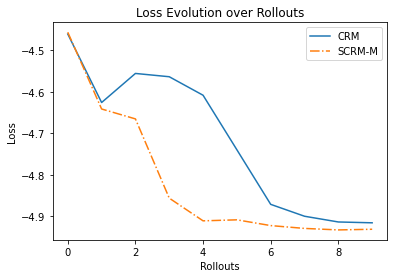

In [53]:
plt.figure()
plt.title('Loss Evolution over Rollouts')
plt.xlabel('Rollouts')
plt.plot(mean_crm_online_losses, '-', label='CRM')
plt.plot(mean_scrm_m_online_losses, '-.', label='SCRM-M')
plt.ylabel('Loss')
plt.legend(loc='upper right')



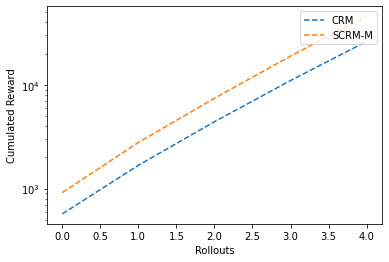

In [47]:
plt.xlabel('Rollouts')
plt.ylabel('Cumulated Reward')
plt.plot(-mean_crm_cumulated_losses, '--', label='CRM')
plt.plot(-mean_scrm_m_cumulated_losses, '--', label='SCRM-M')
plt.legend(loc='upper right')
plt.yscale('log')

## Sequential with past information

### Naive Multi IPS

In [32]:
### Utilities

def get_all_data(logging_actions, logging_contexts, logging_losses, logging_propensities):
    all_logging_actions = np.concatenate(logging_actions)
    all_logging_contexts = np.concatenate(logging_contexts)
    all_logging_losses = np.concatenate(logging_losses)
    all_logging_propensities = np.concatenate(logging_propensities)
    return all_logging_actions, all_logging_contexts, all_logging_losses, all_logging_propensities

def update_past_data(data, samples):
    return np.hstack([data, samples])

In [98]:
scrm_nmips_histories = []

def scrm_nmips_experiment(random_seed, dataset_name, settings):

    dataset = get_dataset_by_name(dataset_name, random_seed)
    start_experiment(random_seed, dataset, 'Naive MultiIPS SCRM')
    
    # Model setting
    contextual_modelling = Model(settings['contextual_modelling'], random_seed)
    estimator = Estimator(contextual_modelling, 'conservative', settings['lambda'])
    scrm_nmips_loss_history = LossHistory("SCRM-NMIPS")
    
    n_samples = T // M
#     optimal_loss, _ = online_evaluation(optimal_mu, contextual_modelling, dataset, random_seed)
    
    # Logging data
    mu = contextual_modelling.create_start_parameter(dataset)
    logging_data = get_logging_data(n_samples, dataset)
    rng = np.random.RandomState(random_seed)
    
    # Setting
    all_actions, all_contexts, all_losses, all_propensities = logging_data
    
    for m in range(M):

        ### Logging data with mixture propensities
        logging_data = all_actions, all_contexts, all_losses, all_propensities

        # Optimization 
        init_parameter = jnp.array(mu, dtype='float32')
        args = logging_data
        optimized_mu, loss_crm = optimize(estimator.objective_function, init_parameter, args)        
        
        ### New logging data
        mu = optimized_mu._value
        loss_crm = loss_crm._value
        
        contexts, potentials = sample_data(n_samples, m, dataset)
        contextual_param = contextual_modelling.get_parameter(mu, contexts)
        actions = rng.normal(contextual_param, logging_scale, n_samples)
        losses = dataset.get_losses_from_actions(potentials, actions)
        propensities = norm(loc=contextual_param, scale=logging_scale).pdf(actions)
        logging_data = actions, contexts, losses, propensities
        
        ## Record 
        online_loss, _ = online_evaluation(mu, contextual_modelling, dataset, random_seed)
#         regret = online_loss - optimal_loss
        regret = 0
        cumulated_losses = np.sum(losses)
        scrm_nmips_loss_history.update(optimized_mu, online_loss, regret, loss_crm, cumulated_losses, n_samples)
        scrm_nmips_loss_history.show_last()
        
        all_actions = update_past_data(all_actions, actions)
        all_contexts = np.vstack([all_contexts, contexts])
        all_losses = update_past_data(all_losses, losses)
        all_propensities = update_past_data(all_propensities, propensities)
        
    return scrm_nmips_loss_history

for random_seed in range(5):
    scrm_nmips_loss_history = scrm_nmips_experiment(random_seed, dataset_name, settings)
    scrm_nmips_histories.append(scrm_nmips_loss_history)

scrm_nmips_losses = np.array([scrm_nmips_loss_history.crm_loss for scrm_nmips_loss_history in scrm_nmips_histories])
mean_scrm_nmips_losses = np.nanmean(scrm_nmips_losses, axis=0)

scrm_nmips_online_losses = np.array([scrm_nmips_loss_history.online_loss for scrm_nmips_loss_history in scrm_nmips_histories])
mean_scrm_nmips_online_losses = np.nanmean(scrm_nmips_online_losses, axis=0)

scrm_nmips_cumulated_losses = np.array([scrm_nmips_loss_history.cumulated_loss for scrm_nmips_loss_history in scrm_nmips_histories])
mean_scrm_nmips_cumulated_losses = np.nanmean(scrm_nmips_cumulated_losses, axis=0)

scrm_nmips_regrets = np.array([scrm_nmips_loss_history.regret for scrm_nmips_loss_history in scrm_nmips_histories])
mean_scrm_nmips_regrets = np.nanmean(scrm_nmips_regrets, axis=0)

*** EXPERIMENT Naive MultiIPS SCRM Random seed: 0 Dataset: warfarin ***
< SCRM-NMIPS CRM loss: 3.49311 Online loss: 21.15391 |beta|=3.08 n=264 >
< SCRM-NMIPS CRM loss: 8.59056 Online loss: 20.43255 |beta|=4.45 n=528 >
< SCRM-NMIPS CRM loss: 12.03445 Online loss: 20.14461 |beta|=4.45 n=792 >
< SCRM-NMIPS CRM loss: 3.72962 Online loss: 14.45230 |beta|=5.47 n=1056 >
< SCRM-NMIPS CRM loss: 4.16718 Online loss: 12.93001 |beta|=5.57 n=1320 >
< SCRM-NMIPS CRM loss: 5.44194 Online loss: 12.99360 |beta|=5.57 n=1584 >
< SCRM-NMIPS CRM loss: 6.77913 Online loss: 12.91535 |beta|=5.57 n=1848 >
< SCRM-NMIPS CRM loss: 5.71585 Online loss: 11.71271 |beta|=5.56 n=2112 >
< SCRM-NMIPS CRM loss: 0.75649 Online loss: 8.83897 |beta|=6.09 n=2376 >
< SCRM-NMIPS CRM loss: 1.44235 Online loss: 8.87832 |beta|=6.09 n=2640 >
*** EXPERIMENT Naive MultiIPS SCRM Random seed: 1 Dataset: warfarin ***
< SCRM-NMIPS CRM loss: 11.62540 Online loss: 26.61723 |beta|=3.00 n=264 >
< SCRM-NMIPS CRM loss: 3.88881 Online loss: 30

### Multi data 

In [69]:
### Multiple IPS

def get_omega_weights(params, all_actions, all_contexts, all_propensities):
    distributions = []
    for param in params:
        contextual_param = linear_modelling(param, all_contexts)
        distributions.append(norm(loc=contextual_param, scale=logging_scale).pdf)
    pi_t = np.array([distribution(all_actions) for distribution in distributions])
    n_pi_t = n_samples * pi_t
    sum_n_pi_t = np.sum(n_pi_t, axis=0)
    all_omegas = all_propensities / sum_n_pi_t
    return all_omegas

def multi_ips_mean(param, all_actions, all_contexts, all_losses, all_propensities, all_omegas):
    
    # Importance weights
    contextual_param = linear_modelling(param, all_contexts)
    importance_weights = pdf(contextual_param, all_actions)/all_propensities
    all_importance_weights = pdf(contextual_param, all_actions)/all_propensities
    
    # Omega weight
    return np.sum(all_omegas * all_losses * all_importance_weights)

class MixtureEstimator():
    def __init__(self, contextual_modelling, mode='conservative', lbd=0.1):
        self.contextual_modelling = contextual_modelling
        self.mode = mode
        bonus = 1 if self.mode == 'conservative' else -1
        self.lbd = bonus * lbd
        self.params = []
        self.rollouts_n_samples = []
        
    def get_mixture_logging_propensities(self, all_policy_samples, all_contexts):
        distributions = []

        for param in self.params:
            contextual_param = self.contextual_modelling.get_parameter(param, all_contexts)
            distributions.append(norm(loc=contextual_param, scale=logging_scale).pdf)
        pi_t = np.array([distribution(all_policy_samples) for distribution in distributions])
        alpha_t = self.rollouts_n_samples/ np.sum(self.rollouts_n_samples)
        mixture_logging_propensities = np.sum(alpha_t * pi_t, axis=0)
        return mixture_logging_propensities
        
    def objective_function(self, param, actions, contexts, losses, mixture_propensities):
        contextual_param = self.contextual_modelling.get_parameter(param, contexts)
        mixture_propensities = jnp.clip(mixture_propensities, 1e-5, None)
        mixture_importance_weights = pdf(contextual_param, actions)/mixture_propensities
        mixture_mean = jnp.mean(losses * mixture_importance_weights)
        mixture_std = jnp.sqrt(jnp.sum(jnp.cov(losses * mixture_importance_weights)))
        return mixture_mean + self.lbd * mixture_std
    
    def update(self, param, rollout_n_samples):
        self.params.append(param)
        self.rollouts_n_samples = np.concatenate([self.rollouts_n_samples, [[rollout_n_samples]]], axis=0)



In [186]:
scrm_mips_histories = []

def scrm_mixture_mips_experiment(random_seed, dataset_name, settings):

    dataset = get_dataset_by_name(dataset_name, random_seed)
    start_experiment(random_seed, dataset, 'Mixture MultiIPS SCRM')
    
    # Model setting
    contextual_modelling = Model(settings['contextual_modelling'], random_seed)
    estimator = MixtureEstimator(contextual_modelling, 'conservative', settings['lambda'])
    scrm_mmips_loss_history = LossHistory("SCRM-MMIPS")
    
    n_samples = T // M
#     optimal_loss, _ = online_evaluation(optimal_mu, contextual_modelling, dataset, random_seed)
    
    # Logging data
    mu = contextual_modelling.create_start_parameter(dataset)
    logging_data = get_logging_data(n_samples, dataset)
    rng = np.random.RandomState(random_seed)
    
    # Setting
    estimator.params.append(mu)
    estimator.rollouts_n_samples = np.array([[n_samples]])
    all_actions, all_contexts, all_losses, all_propensities = logging_data
    
    scaler = preprocessing.MinMaxScaler().fit(all_contexts)
    all_contexts = scaler.transform(all_contexts)

    for m in range(M):

        mixture_logging_propensities = estimator.get_mixture_logging_propensities(all_actions, all_contexts)

        ### Logging data with mixture propensities
        logging_data = all_actions, all_contexts, all_losses, mixture_logging_propensities

        # Optimization 
        init_parameter = jnp.array(mu, dtype='float32')
        args = logging_data
        optimized_mu, loss_crm = optimize(estimator.objective_function, init_parameter, args)        
        
        ### New logging data
        mu = optimized_mu._value
        loss_crm = loss_crm._value
        estimator.update(optimized_mu, n_samples)
        
        contexts, potentials = sample_data(n_samples, m, dataset)
        contextual_param = contextual_modelling.get_parameter(mu, contexts)
        actions = rng.normal(contextual_param, logging_scale, n_samples)
        losses = dataset.get_losses_from_actions(potentials, actions)
        propensities = norm(loc=contextual_param, scale=logging_scale).pdf(actions)
        logging_data = actions, contexts, losses, propensities
        
        ## Record 
        online_loss, _ = online_evaluation(mu, contextual_modelling, dataset, random_seed)
#         regret = online_loss - optimal_loss
        regret = 0
        cumulated_losses = np.sum(losses)
        
        scrm_mmips_loss_history.update(optimized_mu, online_loss, regret, loss_crm, cumulated_losses, n_samples)
        scrm_mmips_loss_history.show_last()
        
        all_actions = update_past_data(all_actions, actions)
        all_contexts = np.vstack([all_contexts, contexts])
        all_losses = update_past_data(all_losses, losses)
        all_propensities = update_past_data(all_propensities, propensities)
        scaler = preprocessing.MinMaxScaler().fit(all_contexts)
        all_contexts = scaler.transform(all_contexts)
        
    return scrm_mmips_loss_history

for random_seed in range(5):
    scrm_mmips_loss_history = scrm_mixture_mips_experiment(random_seed, dataset_name, settings)
    scrm_mips_histories.append(scrm_mmips_loss_history)
        
scrm_mmips_losses = np.array([scrm_mmips_loss_history.crm_loss for scrm_mmips_loss_history in scrm_mips_histories])
mean_scrm_mmips_losses = np.nanmean(scrm_mmips_losses, axis=0)

scrm_mmips_online_losses = np.array([scrm_mmips_loss_history.online_loss for scrm_mmips_loss_history in scrm_mips_histories])
mean_scrm_mmips_online_losses = np.nanmean(scrm_mmips_online_losses, axis=0)

scrm_mmips_cumulated_losses = np.array([scrm_mmips_loss_history.cumulated_loss for scrm_mmips_loss_history in scrm_mips_histories])
mean_scrm_mmips_cumulated_losses = np.nanmean(scrm_mmips_cumulated_losses, axis=0)

scrm_mmips_regrets = np.array([scrm_mmips_loss_history.regret for scrm_mmips_loss_history in scrm_mips_histories])
mean_scrm_mmips_regrets = np.nanmean(scrm_mmips_regrets, axis=0)

*** EXPERIMENT Mixture MultiIPS SCRM Random seed: 0 Dataset: warfarin ***
< SCRM-MMIPS CRM loss: 0.00000 Online loss: 280.30501 |beta|=13.40 n=264 >
< SCRM-MMIPS CRM loss: 0.00000 Online loss: 280.58014 |beta|=13.52 n=528 >
< SCRM-MMIPS CRM loss: 0.00000 Online loss: 280.51642 |beta|=13.52 n=792 >
< SCRM-MMIPS CRM loss: 0.00000 Online loss: 280.49020 |beta|=13.54 n=1056 >
< SCRM-MMIPS CRM loss: 0.00000 Online loss: 280.49020 |beta|=13.54 n=1320 >
< SCRM-MMIPS CRM loss: 0.00000 Online loss: 280.49020 |beta|=13.54 n=1584 >
< SCRM-MMIPS CRM loss: 0.00000 Online loss: 280.49020 |beta|=13.54 n=1848 >
< SCRM-MMIPS CRM loss: 0.00000 Online loss: 280.49020 |beta|=13.54 n=2112 >
< SCRM-MMIPS CRM loss: 0.00000 Online loss: 280.49020 |beta|=13.54 n=2376 >
< SCRM-MMIPS CRM loss: 0.00000 Online loss: 280.49020 |beta|=13.54 n=2640 >
*** EXPERIMENT Mixture MultiIPS SCRM Random seed: 1 Dataset: warfarin ***
< SCRM-MMIPS CRM loss: 0.00000 Online loss: 26.76441 |beta|=42.08 n=264 >
< SCRM-MMIPS CRM loss

### Plot results

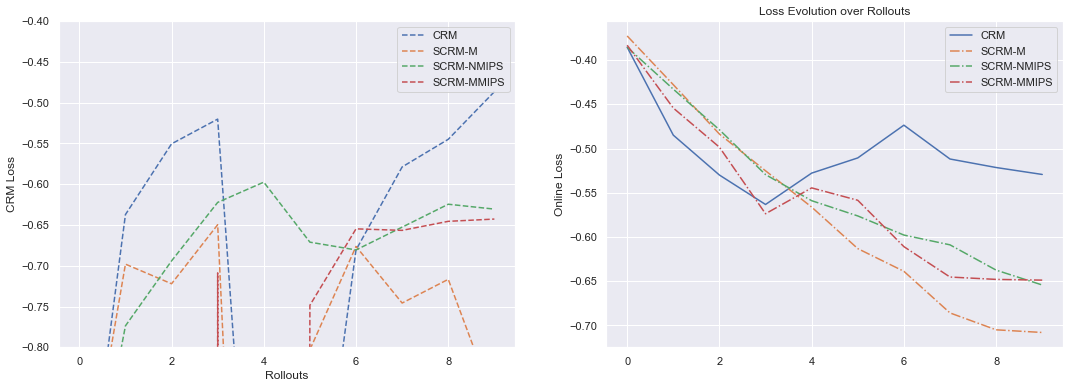

In [49]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plt.title('Loss Evolution over Rollouts')
ax.set_xlabel('Rollouts')
ax.set_ylabel('CRM Loss')
ax.plot(mean_crm_losses, '--', label='CRM')
ax.plot(mean_scrm_m_losses, '--', label='SCRM-M')
ax.plot(mean_scrm_nmips_losses, '--', label='SCRM-NMIPS')
ax.plot(mean_scrm_mmips_losses, '--', label='SCRM-MMIPS')
ax.set_ylim(-0.8, -0.4)
ax.legend(loc='upper right')

ax2.plot(mean_crm_online_losses, '-', label='CRM')
ax2.plot(mean_scrm_m_online_losses, '-.', label='SCRM-M')
ax2.plot(mean_scrm_nmips_online_losses, '-.', label='SCRM-NMIPS')
ax2.plot(mean_scrm_mmips_online_losses,'-.', label='SCRM-MMIPS')
# ax2.plot(batch_kucb_online_losses, label='Batch-KUCB')
# ax2.plot(batch_sbpe_online_losses, label='SBPE')

ax2.set_ylabel('Online Loss')
ax2.legend(loc='upper right')

### SCRM vs CRM

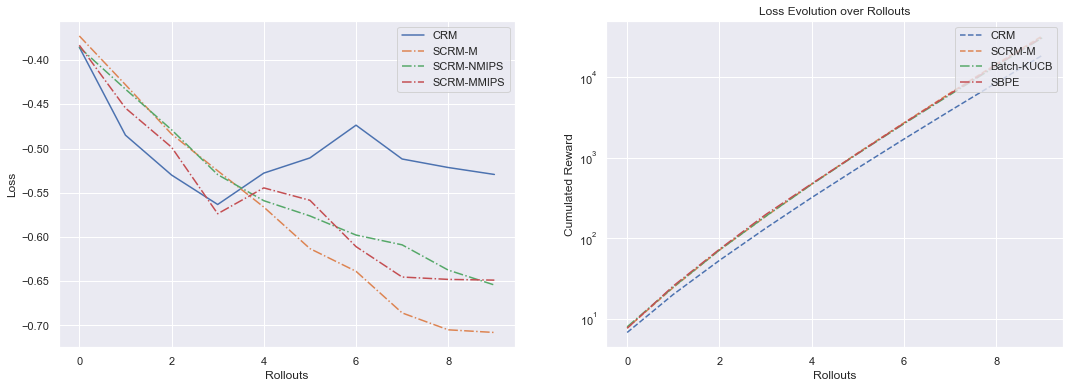

In [53]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plt.title('Loss Evolution over Rollouts')
ax.set_xlabel('Rollouts')
ax.plot(mean_crm_online_losses, '-', label='CRM')
ax.plot(mean_scrm_m_online_losses, '-.', label='SCRM-M')
ax.plot(mean_scrm_nmips_online_losses, '-.', label='SCRM-NMIPS')
ax.plot(mean_scrm_mmips_online_losses,'-.', label='SCRM-MMIPS')
ax.set_ylabel('Loss')
ax.legend(loc='upper right')

# ax2.set_xlabel('Rollouts')
# ax2.set_ylabel('Regret')
# ax2.plot(mean_crm_regrets, '--', label='CRM')
# ax2.plot(mean_scrm_m_regrets, '--', label='SCRM-M')
# ax2.plot(mean_scrm_nmips_regrets, '--', label='SCRM-NMIPS')
# ax2.plot(mean_scrm_mmips_regrets, '--', label='SCRM-MMIPS')
# ax2.legend(loc='lower right')
# ax2.set_yscale('log')

ax2.set_xlabel('Rollouts')
ax2.set_ylabel('Cumulated Reward')
ax2.plot(-mean_crm_cumulated_losses, '--', label='CRM')
ax2.plot(-mean_scrm_m_cumulated_losses, '--', label='SCRM-M')
ax2.plot(-mean_scrm_nmips_cumulated_losses, '-.', label='Batch-KUCB')
ax2.plot(-mean_scrm_mmips_cumulated_losses,'-.', label='SBPE')
ax2.legend(loc='upper right')
ax2.set_yscale('log')

# ax2.plot(batch_kucb_online_losses, label='Batch-KUCB')
# ax2.plot(batch_sbpe_online_losses, label='SBPE')



### SCRM vs baselines

NameError: name 'mean_scrm_m_online_losses' is not defined

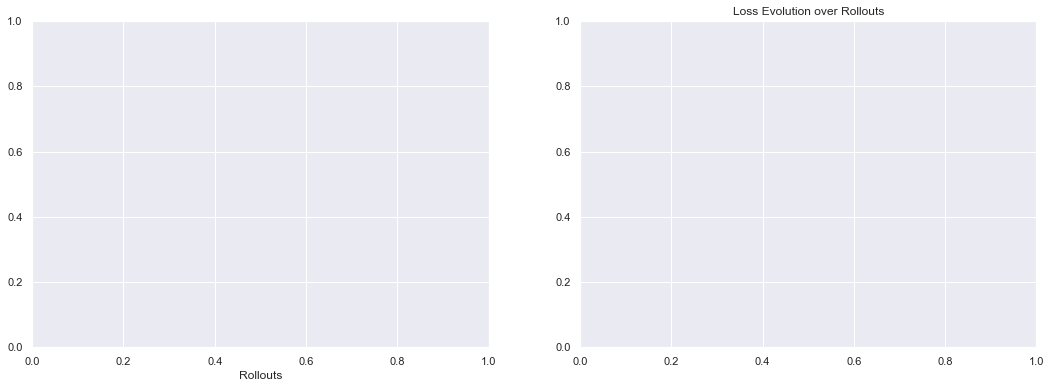

In [16]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plt.title('Loss Evolution over Rollouts')
ax.set_xlabel('Rollouts')
# ax.plot(mean_crm_online_losses, '-', label='CRM')
ax.plot(mean_scrm_m_online_losses, '-.', label='SCRM-M')
ax.plot(batch_kucb_online_losses, '-.', label='Batch-KUCB')
ax.plot(batch_sbpe_online_losses,'-.', label='SBPE')
ax.set_ylabel('Loss')
ax.legend(loc='upper right')

ax2.set_xlabel('Rollouts')
ax2.set_ylabel('Cumulated Loss')
# ax2.plot(mean_crm_cumulated_losses, '--', label='CRM')
ax2.plot(mean_scrm_m_cumulated_losses, '--', label='SCRM-M')
ax2.plot(batch_kucb_cumulated_losses, '-.', label='Batch-KUCB')
ax2.plot(batch_sbpe_cumulated_losses,'-.', label='SBPE')
ax2.legend(loc='upper right')


# ax2.plot(batch_kucb_online_losses, label='Batch-KUCB')
# ax2.plot(batch_sbpe_online_losses, label='SBPE')



# Batch bandits

In [4]:
from src.batch_bandits import Polynomial, BatchKernelUCB, SBPE

from tqdm import tqdm

class Environment:

    def __init__(self, dataset, n_logging_samples):
        self.dataset = dataset
        self.n_logging_samples = n_logging_samples

    def sample_data(self, n):
        return self.dataset.sample_data(n_samples=n)

    def sample_reward(self, actions, labels):
        actions = np.squeeze(actions)
        return - self.dataset.get_losses_from_actions(labels, actions)

    def get_anchor_points(self):
        return np.arange(-5, 5, 0.5)
    
    def get_logging_data(self):
        actions, contexts, losses, _, _ = self.dataset.sample_logged_data(self.n_logging_samples)
        return actions, contexts, -losses


def instantiate_metrics():
    return {
        'time': [],
        'online_loss': [],
        'regret': [],
        'cumulated_loss': [],
    }



In [56]:
settings = {
    'agent': 'Batch-KUCB',
    'T': T,
    'random_seed': 42,
    'reg_lambda': 1,
}

n_logging_samples = 10
M = 10

def get_agent(settings, kernel):
    if settings['agent'] == 'Batch-KUCB':
        return BatchKernelUCB(settings, kernel)
    else:
        return SBPE(settings, kernel)

def batch_bandit_experiment(random_seed, dataset_name, settings):
    
    dataset = get_dataset_by_name(dataset_name, random_seed)

    start_experiment(random_seed, dataset, settings['agent'])
    
    # Model setting
    env = Environment(dataset, n_logging_samples)
    kernel = Polynomial(settings)
    agent = get_agent(settings, kernel)
    agent.beta_t = 0.1
    agent.instantiate(env)
    metrics = instantiate_metrics()
    best_strategy_rewards = []

    t0 = time.time()

    batch_size = n_logging_samples
    for step in tqdm(range(M)):

        # choose a random context.
        batch_size *= 2
        contexts, labels = env.sample_data(n=batch_size)
        # iterate learning algorithm for 1 round.
        actions = agent.sample_actions(contexts)
        rewards = env.sample_reward(actions, labels)

        agent.update_agent(contexts, actions, rewards)
        # get best_strategy's reward for the current context.
    #     best_strategy_rewards.append(env.get_best_reward_in_context(context, label))
        t = time.time() - t0
        metrics['time'].append(t)
#         average_reward = np.mean(agent.past_rewards[1:])
        metrics['online_loss'].append(-np.mean(agent.past_rewards[-batch_size:]))
        metrics['cumulated_loss'].append(np.sum(-agent.past_rewards[1:]))
        print('Rollout {}, Online reward: {}'.format(step, -metrics['online_loss'][-1]))

    batch_online_losses = np.array([online_loss._value for online_loss in metrics['online_loss']])
    batch_cumulated_losses = np.array([cumulated_loss._value for cumulated_loss in metrics['cumulated_loss']])
    return np.expand_dims(batch_online_losses, axis=0), np.expand_dims(batch_cumulated_losses, axis=0)


batch_bandit_online_losses = []
batch_bandit_cumulated_losses = []

for random_seed in range(5):
    online_losses, cumulated_losses = batch_bandit_experiment(random_seed, dataset_name, settings)
    batch_bandit_online_losses.append(online_losses)
    batch_bandit_cumulated_losses.append(cumulated_losses)

batch_bandit_online_losses = np.concatenate(batch_bandit_online_losses, axis=0)
batch_kucb_online_losses, batch_k_ucb_online_losses_std = np.mean(batch_bandit_online_losses, axis=0), np.std(batch_bandit_online_losses, axis=0)

batch_bandit_cumulated_losses = np.concatenate(batch_bandit_cumulated_losses, axis=0)
batch_kucb_cumulated_losses, batch_k_ucb_cumulated_losses_std = np.mean(batch_bandit_cumulated_losses, axis=0), np.std(batch_bandit_cumulated_losses, axis=0)

*** EXPERIMENT Batch-KUCB Random seed: 0 Dataset: noisymoons ***
 40%|█████████████████▌                          | 4/10 [00:00<00:00, 15.38it/s]

Rollout 0, Online reward: 0.6001645922660828
Rollout 1, Online reward: 0.4699372947216034
Rollout 2, Online reward: 0.693317711353302
Rollout 3, Online reward: 0.6968349814414978
Rollout 4, Online reward: 0.7173887491226196


 60%|██████████████████████████▍                 | 6/10 [00:00<00:00,  6.78it/s]

Rollout 5, Online reward: 0.7113978266716003
Rollout 6, Online reward: 0.6822718977928162


 80%|███████████████████████████████████▏        | 8/10 [00:08<00:03,  1.67s/it]

Rollout 7, Online reward: 0.6839162111282349


 90%|███████████████████████████████████████▌    | 9/10 [00:56<00:11, 11.71s/it]

Rollout 8, Online reward: 0.5668196678161621


100%|███████████████████████████████████████████| 10/10 [06:59<00:00, 41.95s/it]
*** EXPERIMENT Batch-KUCB Random seed: 1 Dataset: noisymoons ***


Rollout 9, Online reward: -0.022950319573283195


 20%|████████▊                                   | 2/10 [00:00<00:00, 15.28it/s]

Rollout 0, Online reward: 0.6204380989074707
Rollout 1, Online reward: 0.7318664193153381
Rollout 2, Online reward: 0.6358234286308289


 40%|█████████████████▌                          | 4/10 [00:00<00:00, 12.24it/s]

Rollout 3, Online reward: 0.6977288126945496
Rollout 4, Online reward: 0.7297350168228149


 60%|██████████████████████████▍                 | 6/10 [00:00<00:00,  5.46it/s]

Rollout 5, Online reward: 0.7264930605888367


 70%|██████████████████████████████▊             | 7/10 [00:02<00:01,  1.95it/s]

Rollout 6, Online reward: 0.694107174873352


 80%|███████████████████████████████████▏        | 8/10 [00:09<00:04,  2.29s/it]

Rollout 7, Online reward: 0.6625233292579651


 80%|███████████████████████████████████▏        | 8/10 [00:20<00:05,  2.62s/it]


KeyboardInterrupt: 

In [112]:
settings = {
    'agent': 'SBPE',
    'T': T,
    'random_seed': 42,
    'reg_lambda': 1e-5,
}
M = 8

kernel = Polynomial(settings)
agent = SBPE(settings, kernel)

batch_bandit_online_losses = []
batch_bandit_cumulated_losses = []

for random_seed in range(10):
    online_losses, cumulated_losses = batch_bandit_experiment(random_seed, dataset_name, settings)
    batch_bandit_online_losses.append(online_losses)
    batch_bandit_cumulated_losses.append(cumulated_losses)

batch_bandit_online_losses = np.concatenate(batch_bandit_online_losses, axis=0)
batch_sbpe_online_losses, batch_sbpe_online_losses_std = np.mean(batch_bandit_online_losses, axis=0), np.std(batch_bandit_online_losses, axis=0)

batch_bandit_cumulated_losses = np.concatenate(batch_bandit_cumulated_losses, axis=0)
batch_sbpe_cumulated_losses, batch_sbpe_cumulated_losses_std = np.mean(batch_bandit_cumulated_losses, axis=0), np.std(batch_bandit_cumulated_losses, axis=0)


*** EXPERIMENT SBPE Random seed: 0 Dataset: noisymoons ***
 38%|████████████████▉                            | 3/8 [00:00<00:00, 21.81it/s]

Online reward: -0.10000001639127731
Online reward: -0.002117246389389038
Online reward: -0.03949412703514099
Online reward: -0.0455208420753479


 75%|█████████████████████████████████▊           | 6/8 [00:00<00:00, 14.39it/s]

Online reward: 0.17864815890789032
Online reward: 0.05791473388671875
Online reward: -0.02374051697552204


100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.15it/s]
*** EXPERIMENT SBPE Random seed: 1 Dataset: noisymoons ***


Online reward: 0.004704478196799755


 50%|██████████████████████▌                      | 4/8 [00:00<00:00, 28.67it/s]

Online reward: 0.5890769362449646
Online reward: -0.09999995678663254
Online reward: 0.36050912737846375
Online reward: 0.2396615594625473
Online reward: -0.0856781154870987
Online reward: 0.10798215866088867


 88%|███████████████████████████████████████▍     | 7/8 [00:00<00:00,  6.29it/s]

Online reward: -0.012212378904223442


100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.20it/s]
*** EXPERIMENT SBPE Random seed: 2 Dataset: noisymoons ***


Online reward: 0.11916790157556534


 38%|████████████████▉                            | 3/8 [00:00<00:00, 24.31it/s]

Online reward: 0.6623274683952332
Online reward: 0.19819919764995575
Online reward: -0.09526938199996948
Online reward: 0.038844164460897446
Online reward: 0.1624966859817505


 75%|█████████████████████████████████▊           | 6/8 [00:00<00:00, 14.54it/s]

Online reward: 0.11595123261213303
Online reward: 0.07875721901655197


100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.16it/s]
*** EXPERIMENT SBPE Random seed: 3 Dataset: noisymoons ***


Online reward: 0.35802802443504333


 38%|████████████████▉                            | 3/8 [00:00<00:00, 29.56it/s]

Online reward: 0.1659092754125595
Online reward: -0.09999995678663254
Online reward: -0.020642369985580444
Online reward: 0.1462685614824295
Online reward: 0.12750661373138428


 75%|█████████████████████████████████▊           | 6/8 [00:00<00:00, 14.41it/s]

Online reward: 0.13772182166576385
Online reward: 0.13042600452899933


100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.12it/s]
*** EXPERIMENT SBPE Random seed: 4 Dataset: noisymoons ***


Online reward: 0.06505250185728073


 50%|██████████████████████▌                      | 4/8 [00:00<00:00, 29.74it/s]

Online reward: -0.10000001639127731
Online reward: -0.03876375034451485
Online reward: 0.06986036151647568
Online reward: 0.1547996699810028
Online reward: 0.12324482202529907
Online reward: 0.028684867545962334


 88%|███████████████████████████████████████▍     | 7/8 [00:01<00:00,  5.99it/s]

Online reward: -0.09984370321035385


100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.15it/s]
*** EXPERIMENT SBPE Random seed: 5 Dataset: noisymoons ***


Online reward: 0.05636269599199295


 50%|██████████████████████▌                      | 4/8 [00:00<00:00, 29.24it/s]

Online reward: -0.10000001639127731
Online reward: -0.0362309031188488
Online reward: -0.024480795487761497
Online reward: -0.10000000149011612
Online reward: 0.020688358694314957
Online reward: 0.07448432594537735


 88%|███████████████████████████████████████▍     | 7/8 [00:00<00:00,  6.32it/s]

Online reward: -0.06023517996072769


100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.23it/s]
*** EXPERIMENT SBPE Random seed: 6 Dataset: noisymoons ***


Online reward: -0.08624713867902756


 50%|██████████████████████▌                      | 4/8 [00:00<00:00, 29.22it/s]

Online reward: -0.04182886704802513
Online reward: -0.015173329971730709
Online reward: 0.061528660356998444
Online reward: 0.04241118207573891
Online reward: -0.07372986525297165
Online reward: -0.024569779634475708


 88%|███████████████████████████████████████▍     | 7/8 [00:01<00:00,  5.90it/s]

Online reward: 0.22030363976955414


100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.09it/s]
*** EXPERIMENT SBPE Random seed: 7 Dataset: noisymoons ***


Online reward: -0.037956733256578445


 38%|████████████████▉                            | 3/8 [00:00<00:00, 20.94it/s]

Online reward: 0.34365710616111755
Online reward: 0.3178836703300476
Online reward: 0.1772085279226303
Online reward: 0.010790384374558926
Online reward: -0.028677960857748985


 75%|█████████████████████████████████▊           | 6/8 [00:00<00:00, 12.74it/s]

Online reward: -0.09016434103250504
Online reward: -0.014382228255271912


100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.04it/s]
*** EXPERIMENT SBPE Random seed: 8 Dataset: noisymoons ***


Online reward: -0.09996749460697174


 38%|████████████████▉                            | 3/8 [00:00<00:00, 27.22it/s]

Online reward: -0.10000001639127731
Online reward: -0.04052574560046196
Online reward: 0.3592087924480438
Online reward: -0.0069081285037100315
Online reward: -0.023232141509652138


 75%|█████████████████████████████████▊           | 6/8 [00:00<00:00, 14.14it/s]

Online reward: -0.08291703462600708
Online reward: 0.05511239171028137


100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.02it/s]
*** EXPERIMENT SBPE Random seed: 9 Dataset: noisymoons ***


Online reward: 0.02018297091126442


 50%|██████████████████████▌                      | 4/8 [00:00<00:00, 29.56it/s]

Online reward: -0.05215660482645035
Online reward: 0.1608698070049286
Online reward: 0.09204912930727005
Online reward: 0.0027879048138856888
Online reward: -0.04128950461745262
Online reward: -0.10000001639127731


 88%|███████████████████████████████████████▍     | 7/8 [00:00<00:00,  6.12it/s]

Online reward: 0.05928536877036095


100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.11it/s]

Online reward: 0.1083894744515419


In [99]:
batch_sbpe_online_losses

array([-0.42547998, -0.6544496 , -0.6454035 , -0.6929121 , -0.71240985,
       -0.7120695 , -0.724742  , -0.72789574], dtype=float32)

In [63]:
array[-5:]

array([95, 96, 97, 98, 99])

In [92]:
batch_kucb_online_losses

array([-0.4058508 , -0.52489346, -0.5379437 , -0.48313928, -0.43111897,
       -0.3787202 , -0.30418026, -0.26423642], dtype=float32)